In [1]:
pip install pymysql sqlalchemy

## Load Data From DB

In [70]:
import pandas as pd
from sqlalchemy import create_engine
host = "localhost"  
user = "username"
password = "password"
database = "ML_Database"
table_name = "Credit_Risk_Predictions"

engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database}")
query = "SELECT * FROM Credit_Risk_Predictions;"
df = pd.read_sql(query, con=engine)
print(df)


       person_age  person_income person_home_ownership  person_emp_length  \
0              22          59000                  RENT              123.0   
1              21           9600                   OWN                5.0   
2              25           9600              MORTGAGE                1.0   
3              23          65500                  RENT                4.0   
4              24          54400                  RENT                8.0   
...           ...            ...                   ...                ...   
32576          57          53000              MORTGAGE                1.0   
32577          54         120000              MORTGAGE                4.0   
32578          65          76000                  RENT                3.0   
32579          56         150000              MORTGAGE                5.0   
32580          66          42000                  RENT                2.0   

           loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \

## EDA 

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.style.use('ggplot')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB
None
         person_age  perso

C:\Users\Bhumi\AppData\Local\Temp\ipykernel_26212\3996617095.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="loan_status", data=df, palette="Set2")


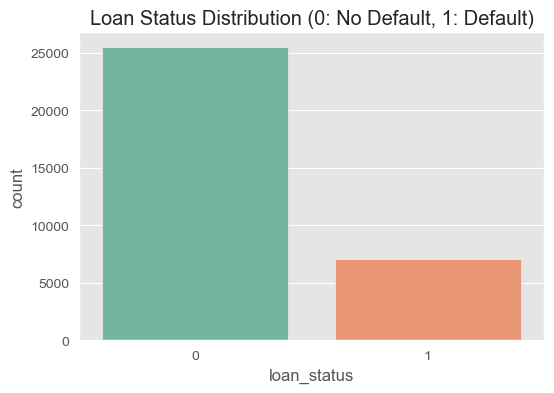

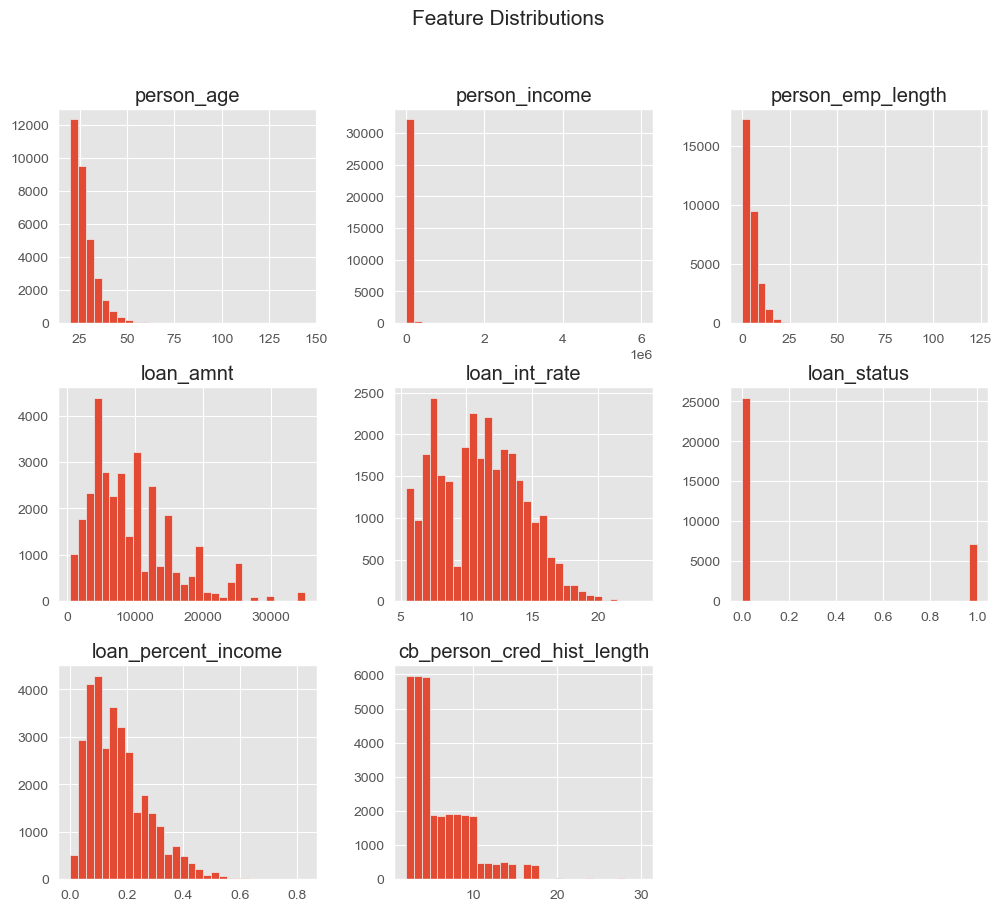

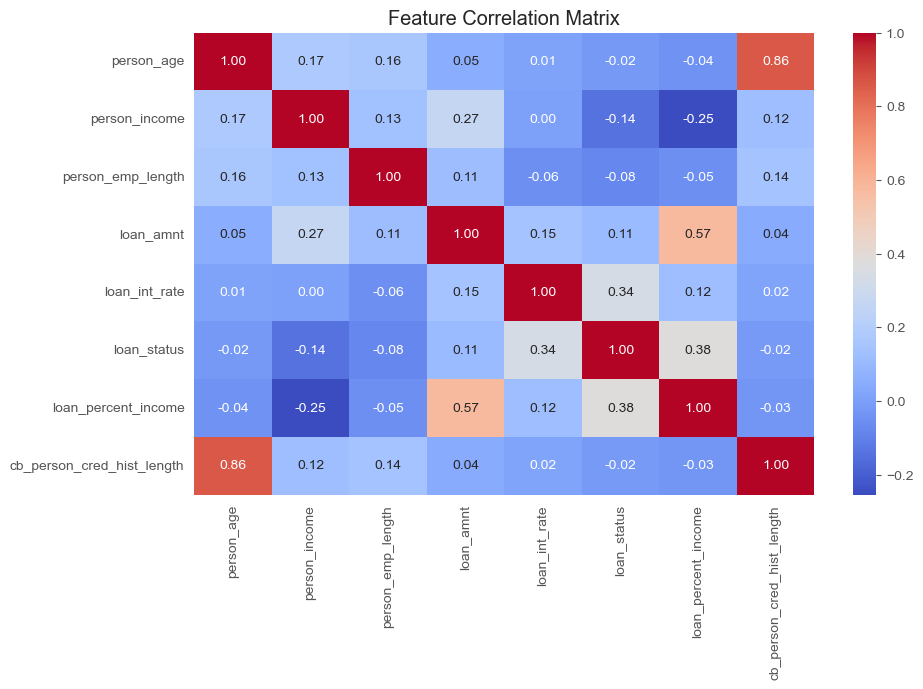

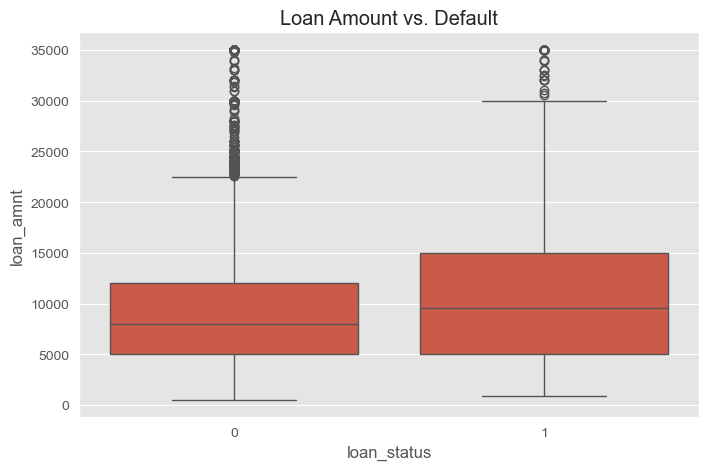

In [50]:
print(df.info())
print(df.describe())

print("\nMissing Values:\n", df.isnull().sum())


# Target Variable Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="loan_status", data=df, palette="Set2")
plt.title("Loan Status Distribution (0: No Default, 1: Default)")
plt.show()

# Numeric Feature Distributions
df.hist(figsize=(12, 10), bins=30)
plt.suptitle("Feature Distributions", fontsize=15)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(exclude='O').corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

# Loan Amount vs. Default Rate
plt.figure(figsize=(8, 5))
sns.boxplot(x="loan_status", y="loan_amnt", data=df)
plt.title("Loan Amount vs. Default")
plt.show()


In [60]:
df.select_dtypes(exclude="O").skew()

person_age                     2.581393
person_income                 32.865349
person_emp_length              2.614455
loan_amnt                      1.192477
loan_int_rate                  0.208550
loan_status                    1.364888
loan_percent_income            1.064669
cb_person_cred_hist_length     1.661790
dtype: float64

-- AVB Task add insights from the visualisations

**NOTE: Target Feature is Imbalanced**

- Balance it out using SMOTE or use Ensemble models

## Model Building

In [84]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
#df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)
#df['loan_int_rate'].fillna(df['loan_int_rate'].mean(), inplace=True) # impute with mean as int rate is normally distributed 

# Encode categorical variables
#categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
#df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

X = df.drop(columns=['loan_status'])  # Features
y = df['loan_status']  # Target variable

smote = SMOTE(sampling_strategy=0.5, random_state=42) 
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Model Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      5075
           1       0.96      0.84      0.90      2567

    accuracy                           0.93      7642
   macro avg       0.94      0.91      0.92      7642
weighted avg       0.94      0.93      0.93      7642

ROC-AUC Score: 0.9678808522724003


**Base Level Model is performing well as Metrics Looks Good**

## Hyperparameter Tuning With XGB Clf

In [86]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, n_iter=20, cv=3,
    scoring='roc_auc', verbose=1, n_jobs=-1, random_state=42
)

random_search.fit(X_train, y_train)
best_xgb = random_search.best_estimator_

y_pred_xgb = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

print("Best Parameters:", random_search.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_xgb))


Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\Bhumi\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:40:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.6}
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      5075
           1       0.96      0.87      0.91      2567

    accuracy                           0.94      7642
   macro avg       0.95      0.92      0.94      7642
weighted avg       0.94      0.94      0.94      7642

ROC-AUC Score: 0.9763539121974436


**XGBoost model outperforms Random Forest with**
 
- Higher ROC-AUC (0.976) → Better discrimination between defaulters & non-defaulters.
  
- Improved Recall (85% vs. 84%) → Capturing more defaulters.
  
- Better Precision (97%) → Fewer false positives

## Insights

C:\Users\Bhumi\AppData\Local\Temp\ipykernel_26212\460974169.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'], palette='viridis')


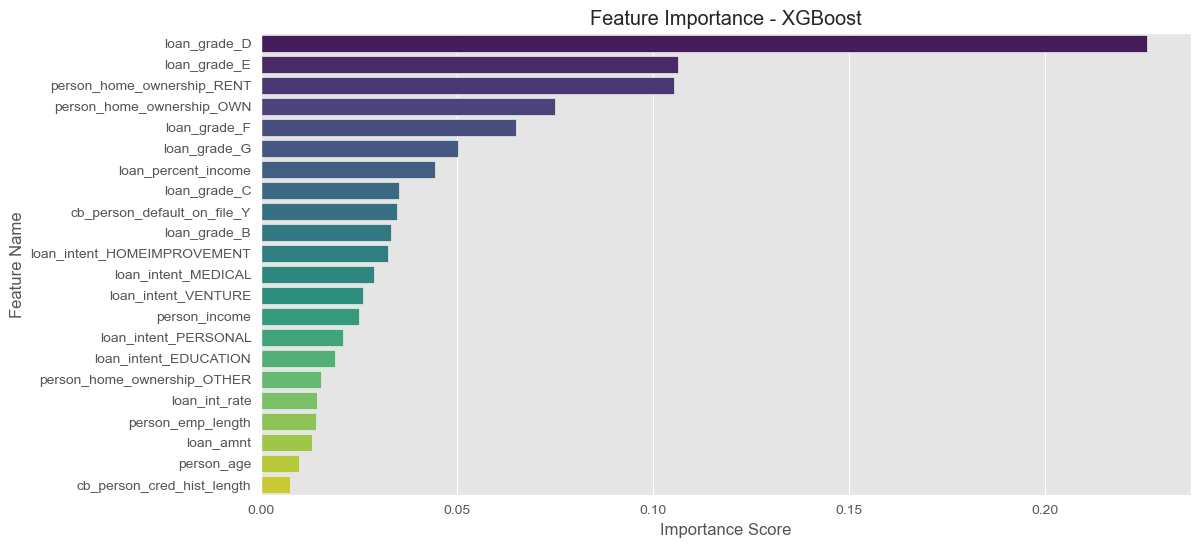

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': best_xgb.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'], palette='viridis')
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.show()


**
## **Oerview**
This analysis evaluates the most influential features driving credit default risk, as determined by the XGBoost model. Understanding these factors can help financial institutions mitigate risk, optimize loan offerings, and improve credit decision-making.

---

## **Top Contributing Features & Insights**

### **1️⃣ Loan Grade (D, E, F, G, C, B)**
🔹 **Observation**: Loan grades (D, E, F) are the most critical predictors of default risk. Borrowers with these grades have a significantly higher chance of defaulting.  
🔹 **Business Impact**: Risky borrowers tend to receive lower grades based on their financial history and creditworthiness. Stricter underwriting policies for lower-grade loans can help reduce defaults.  

### **2️⃣ Home Ownership (Rent, Own)**
🔹 **Observation**: Renters have a higher risk of default compared to homeowners.  
🔹 **Reasoning**: Renters typically have less financial stability than homeowners, who have an asset base.  
🔹 **Actionable Insight**: Offering better loan terms to homeowners while increasing scrutiny for renters can improve loan portfolio performance.  

### **3️⃣ Loan Percent Income**
🔹 **Observation**: The percentage of income allocated to loan repayments is a key driver of default.  
🔹 **Business Impact**: Higher debt-to-income ratios indicate financial strain, increasing the likelihood of missed payments.  
🔹 **Recommendation**: Implement strict income-to-loan ratio thresholds to ensure borrowers have sufficient disposable income.  

### **4️⃣ Loan Intent (Home Improvement, Medical, Venture, Personal, Education)**
🔹 **Observation**: Loans taken for **Home Improvement** and **Medical Expenses** have higher default risks.  
🔹 **Business Impact**: Emergency-based loans tend to have a higher risk due to unexpected financial stress.  
🔹 **Actionable Insight**: Financial institutions can introduce specialized repayment plans for medical loans to reduce delinquency rates.  

### **5️⃣ Credit Bureau Default History (Yes)**
🔹 **Observation**: If a borrower has previously defaulted, they are significantly more likely to default again.  
🔹 **Business Impact**: Credit default history is a ccial factor in risk assessment.  
🔹 **Actionable Insight**: Strict lending policies for applicants with prior defaults can minimize bad debt accumulation.  

### **6️⃣ Loan Amount & Interest Rate**
🔹 **Observation**: Larger loan amounts and higher interest rates slightlyntribute to increased default risk.  
🔹 **Business Impact**: Borrowers who take larger loans or have high interest rates are under more financial pressure.  
🔹 **Recommendation**: Credit risk teams should tailor loan amounts based on financial background and repayment history.  

### **7️⃣ Employment Length**
🔹 **Observation**: Longer employment history reduces default risk, while shorter job tenure increases risk.  
🔹 **Business Impact**: Stable employment indicates consistent income, reducing the likelihood of missed payments.  
🔹 **Recommendation**: Job tenure should be factored into credit assessments, with stricter evaluations for applicants with unstable employment history.  

---

## **Key Takeaways & Strategic Actions**
✅ **Improve Loan Approval Criteria** → Focus on high-risk groups such as renters, borrowers with prior defaults, and applicants with high debt-to-income ratios.  
✅ **Optimize Interest Rates** → Adjust interest rates based on risk levels to balance profitability and risk mitigation.  
✅ **Enhance Credit Monitoring** → Develop risk-based monitoring strategies fsights. 🚀📊

## Save Model Predicted Defaulters Results to DB

In [95]:

from sqlalchemy import create_engine

predictions_df = X_test.copy()  
predictions_df = pd.DataFrame(predictions_df, columns=X.columns)  
predictions_df['Actual_Loan_Status'] = y_test.values  
predictions_df['Predicted_Loan_Status'] = y_pred_xgb 
predictions_df['Prediction_Probability'] = y_proba_xgb  

predictions_df.to_sql(name='Defaulters_Predicted', con=engine, if_exists='replace', index=False)

print("Predictions saved successfully to 'Defaulters_Predicted' table in MySQL!")


Predictions saved successfully to 'Defaulters_Predicted' table in MySQL!


C:\Users\Bhumi\AppData\Local\Temp\ipykernel_26212\1003541719.py:9: UserWarning: The provided table name 'Defaulters_Predicted' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  predictions_df.to_sql(name='Defaulters_Predicted', con=engine, if_exists='replace', index=False)
